# Análisis de datos

En este notebook, voy a realizar un análisis de los datos para extraer alguna conclusión que guíe el futuro desarrollo del modelo predictivo.

Para ello utilizo mi propio módulo 'MyUtils' en el que están funciones para carga de archivos csv, integración de indicadores técnicos, visualización de datos, etc...


In [90]:
####################################################################################
# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
from pandas.plotting import scatter_matrix
import numpy as np

####################################################################################
# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
from sklearn.externals import joblib
import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')

####################################################################################
# TA-Lib: instalación y carga de la librería
import talib

####################################################################################
# Otras utilidades
import datetime
import time
import os
import sys
import math

In [2]:
import MyUtils as utils
print('Ready!')

Ready!


##### Cargo el histórico de un archivo csv

Además, hago lo siguiente:

- Obtengo todos los datos hora a hora y los que faltan los relleno con el último dato anterior válido.
- Elimino los días sin cotización (fines de semana).

In [3]:
# Carga el histórico
df = utils.load_hist('EURUSD_H1.csv', sep=';', remove_weekends=True)
df.head()


Deleting weekends...


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,TICKVOL,VOL,SPREAD
2001-01-01 01:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0,60,0,5.0,0.0,50.0
2001-01-01 02:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0,120,0,5.0,0.0,50.0
2001-01-01 03:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0,180,0,5.0,0.0,50.0
2001-01-01 04:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0,240,0,5.0,0.0,50.0
2001-01-01 05:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0,300,0,5.0,0.0,50.0


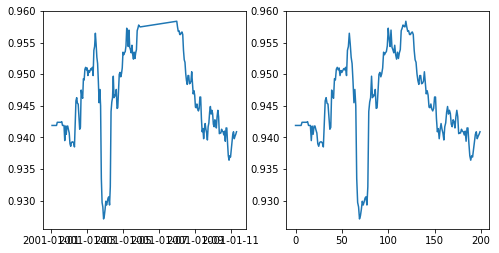

In [4]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(df.CLOSE[0:200])
plt.subplot(1,2,2)
plt.plot(df.CLOSE.values[0:200])

#### Incluyo diferentes indicadores técnicos como MACD, RSI, Bollinger, etc...

In [5]:
df = utils.add_indicators(df, applied=['CLOSE'], base_cols=['OPEN','HIGH','LOW','CLOSE','OC2','HLC3','OHLC4'])
df.head(1)

,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,BB_UPPER_CLOSE,BB_MIDDLE_CLOSE,BB_LOWER_CLOSE,...,BB_WIDTH_SMA50_CLOSE,SMA4_CLOSE,SMA16_CLOSE,SMA40_CLOSE,MACD_CLOSE,MACD_SIG_CLOSE,MACD_HIST_CLOSE,RSI_CLOSE,WILLR,ATR
2001-01-03 21:00:00,0.9298,0.9301,0.9277,0.929,0.9294,0.928933,0.92915,0.963335,0.947855,0.932375,...,0.984695,0.9343,0.947169,0.946955,-0.003375,-0.000444,-0.00293,22.470458,-94.966443,0.003942


#### Incluyo diferentes columnas de salida

Incluyo las siguientes predicciones:

1. Predicción de la diferencia de cierre entre el instante actual y las siguientes N horas
2. Máximo drawdown 'bullish' para ese periodo
3. Máximo drawdown 'bearish para ese periodo

In [17]:
forecast_candles = 6
df['OUT_DIF'] = 0.0
df['OUT_DRAWD_BULL'] = 0.0
df['OUT_DRAWD_BEAR'] = 0.0
values = df.CLOSE.values
for i in range(df.shape[0]-forecast_candles):
  v0,v1,v2 = utils.drawdown_calculator(values[i:i+forecast_candles])
  df.iloc[i]['OUT_DIF'], df.iloc[i]['OUT_DRAWD_BULL'], df.iloc[i]['OUT_DRAWD_BEAR'] = v0, v1, v2

# elimino las últimas 'forecast_candles' filas ya que no contienen datos válidos
df = df[:-forecast_candles]
print('Done!')


Done!


r: 22856
Calculado: 0.0029000000000001247 -0.0010999999999998789 0.0040000000000000036
En tabla: 0.0029000000000001247 -0.0010999999999998789 0.0040000000000000036


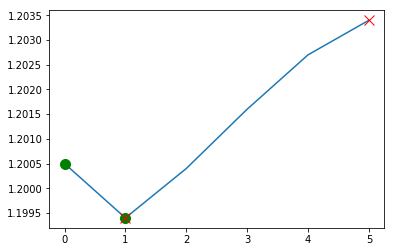

In [44]:
# chequeo de forma aleatoria que las salidas están bien formadas:
r = np.random.randint(df.shape[0]-forecast_candles)
v0,v1,v2 = utils.drawdown_calculator(df.CLOSE.values[r:r+forecast_candles], True)
print('r:',r)
print('Calculado:',v0,v1,v2)
print('En tabla:',df.iloc[r]['OUT_DIF'],df.iloc[r]['OUT_DRAWD_BULL'],df.iloc[r]['OUT_DRAWD_BEAR'])


#### Incluyo patrones de vela

Añado todos los patrones que proporciona la librería TA-Lib:

- Los valores (-1) indican la presencia de una vela 'bullish'
- Los valores (+1) indican la presencia de una vela 'bearish'

Además añado las columnas de salida a predecir:

- OUT_DIR: Dirección del cierre en la próxima vela (+1(crece sobre), -1(cae bajo) la desviación estándar del cierre diario
- OUT_QTY: Cantidad del movimiento en la diferencia del cierre diario

In [45]:
# añado todos los patrones de velas de la librería TALib
df = utils.add_candle_patterns(df)
df.head()

,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,BB_UPPER_CLOSE,BB_MIDDLE_CLOSE,BB_LOWER_CLOSE,...,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS
2001-01-03 21:00:00,0.9298,0.9301,0.9277,0.9290,0.92940,0.928933,0.929150,0.963335,0.947855,0.932375,...,0,0,0,0,0,0,0,0,0,0
2001-01-03 22:00:00,0.9290,0.9296,0.9270,0.9271,0.92805,0.927900,0.928175,0.964534,0.946680,0.928826,...,0,0,0,0,0,0,0,0,0,0
2001-01-03 23:00:00,0.9270,0.9283,0.9262,0.9276,0.92730,0.927367,0.927275,0.965136,0.945545,0.925954,...,0,0,0,0,0,0,0,0,0,0
2001-01-04 00:00:00,0.9276,0.9288,0.9269,0.9286,0.92810,0.928100,0.927975,0.965212,0.944445,0.923678,...,0,0,0,0,0,0,0,0,0,0
2001-01-04 01:00:00,0.9287,0.9312,0.9284,0.9299,0.92930,0.929833,0.929550,0.964862,0.943395,0.921928,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# Limito el valor de los patrones al rango (-1,+1)
for c in df.columns:
  if 'CDL' in c:
    vmax = max(abs(df[c].max()), abs(df[c].min()))
    if vmax != 0.0:
      df[c] = df[c]/vmax
    
for c in df.columns:
  print(c,':',df[c].describe()['max'])

OPEN : 1.6015
HIGH : 1.6038
LOW : 1.5992
CLOSE : 1.6016
OC2 : 1.6006
HLC3 : 1.6006
OHLC4 : 1.6005249999999998
BB_UPPER_CLOSE : 1.6046511646182784
BB_MIDDLE_CLOSE : 1.598254999999991
BB_LOWER_CLOSE : 1.5957986001523528
BB_WIDTH_CLOSE : 0.0797492670862825
BB_PERCENT_CLOSE : 1.5897247321435966
BB_WIDTH_SMA50_CLOSE : 2.283743844977028
SMA4_CLOSE : 1.5998500000000013
SMA16_CLOSE : 1.5986062499999945
SMA40_CLOSE : 1.5949025000000052
MACD_CLOSE : 0.013127821459353317
MACD_SIG_CLOSE : 0.012040058549434126
MACD_HIST_CLOSE : 0.004799704358736596
RSI_CLOSE : 96.78748813965564
WILLR : -0.0
ATR : 0.01253704413370088
OUT_DIF : 0.03820000000000001
OUT_DRAWD_BULL : 0.0
OUT_DRAWD_BEAR : 0.039799999999999836
CDL2CROWS : 0.0
CDL3BLACKCROWS : 0.0
CDL3INSIDE : 1.0
CDL3LINESTRIKE : 1.0
CDL3OUTSIDE : 1.0
CDL3STARSINSOUTH : 0.0
CDL3WHITESOLDIERS : 1.0
CDLABANDONEDBABY : 0.0
CDLADVANCEBLOCK : 0.0
CDLBELTHOLD : 1.0
CDLBREAKAWAY : 1.0
CDLCLOSINGMARUBOZU : 1.0
CDLCONCEALBABYSWALL : 1.0
CDLCOUNTERATTACK : 1.0
CDLD

#### Creo listas de features por tipo

In [49]:
# columnas relativas al precio
cols_price = ['OPEN','HIGH','LOW','CLOSE','OC2','HLC3','OHLC4']
cols_price

['OPEN', 'HIGH', 'LOW', 'CLOSE', 'OC2', 'HLC3', 'OHLC4']

In [50]:
# columnas relativas a patrones de velas
cols_patterns = [c for c in df.columns if 'CDL' in c]
cols_patterns

['CDL2CROWS',
 'CDL3BLACKCROWS',
 'CDL3INSIDE',
 'CDL3LINESTRIKE',
 'CDL3OUTSIDE',
 'CDL3STARSINSOUTH',
 'CDL3WHITESOLDIERS',
 'CDLABANDONEDBABY',
 'CDLADVANCEBLOCK',
 'CDLBELTHOLD',
 'CDLBREAKAWAY',
 'CDLCLOSINGMARUBOZU',
 'CDLCONCEALBABYSWALL',
 'CDLCOUNTERATTACK',
 'CDLDARKCLOUDCOVER',
 'CDLDOJI',
 'CDLDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLEVENINGDOJISTAR',
 'CDLEVENINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLHARAMI',
 'CDLHARAMICROSS',
 'CDLHIGHWAVE',
 'CDLHIKKAKE',
 'CDLHIKKAKEMOD',
 'CDLHOMINGPIGEON',
 'CDLIDENTICAL3CROWS',
 'CDLINNECK',
 'CDLINVERTEDHAMMER',
 'CDLKICKING',
 'CDLKICKINGBYLENGTH',
 'CDLLADDERBOTTOM',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLMATCHINGLOW',
 'CDLMATHOLD',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDLONNECK',
 'CDLPIERCING',
 'CDLRICKSHAWMAN',
 'CDLRISEFALL3METHODS',
 'CDLSEPARATINGLINES',
 'CDLSHOOTINGSTAR',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'CDLSTALLEDPATTERN',
 

In [53]:
# columnas relativas a las salidas a predecir
cols_out = [c for c in df.columns if 'OUT_' in c]
cols_out

['OUT_DIF', 'OUT_DRAWD_BULL', 'OUT_DRAWD_BEAR']

In [72]:
# columnas relativas a indicadores técnicos
l = df.columns.tolist()
for c in (cols_price + cols_patterns + cols_out):
  l.remove(c)
cols_indicators = l
cols_indicators

['BB_UPPER_CLOSE',
 'BB_MIDDLE_CLOSE',
 'BB_LOWER_CLOSE',
 'BB_WIDTH_CLOSE',
 'BB_PERCENT_CLOSE',
 'BB_WIDTH_SMA50_CLOSE',
 'SMA4_CLOSE',
 'SMA16_CLOSE',
 'SMA40_CLOSE',
 'MACD_CLOSE',
 'MACD_SIG_CLOSE',
 'MACD_HIST_CLOSE',
 'RSI_CLOSE',
 'WILLR',
 'ATR']

### Análisis estadístico

A continuación voy a realizar un análisis para ver si consigo extraer algo en claro de los datos de entrada

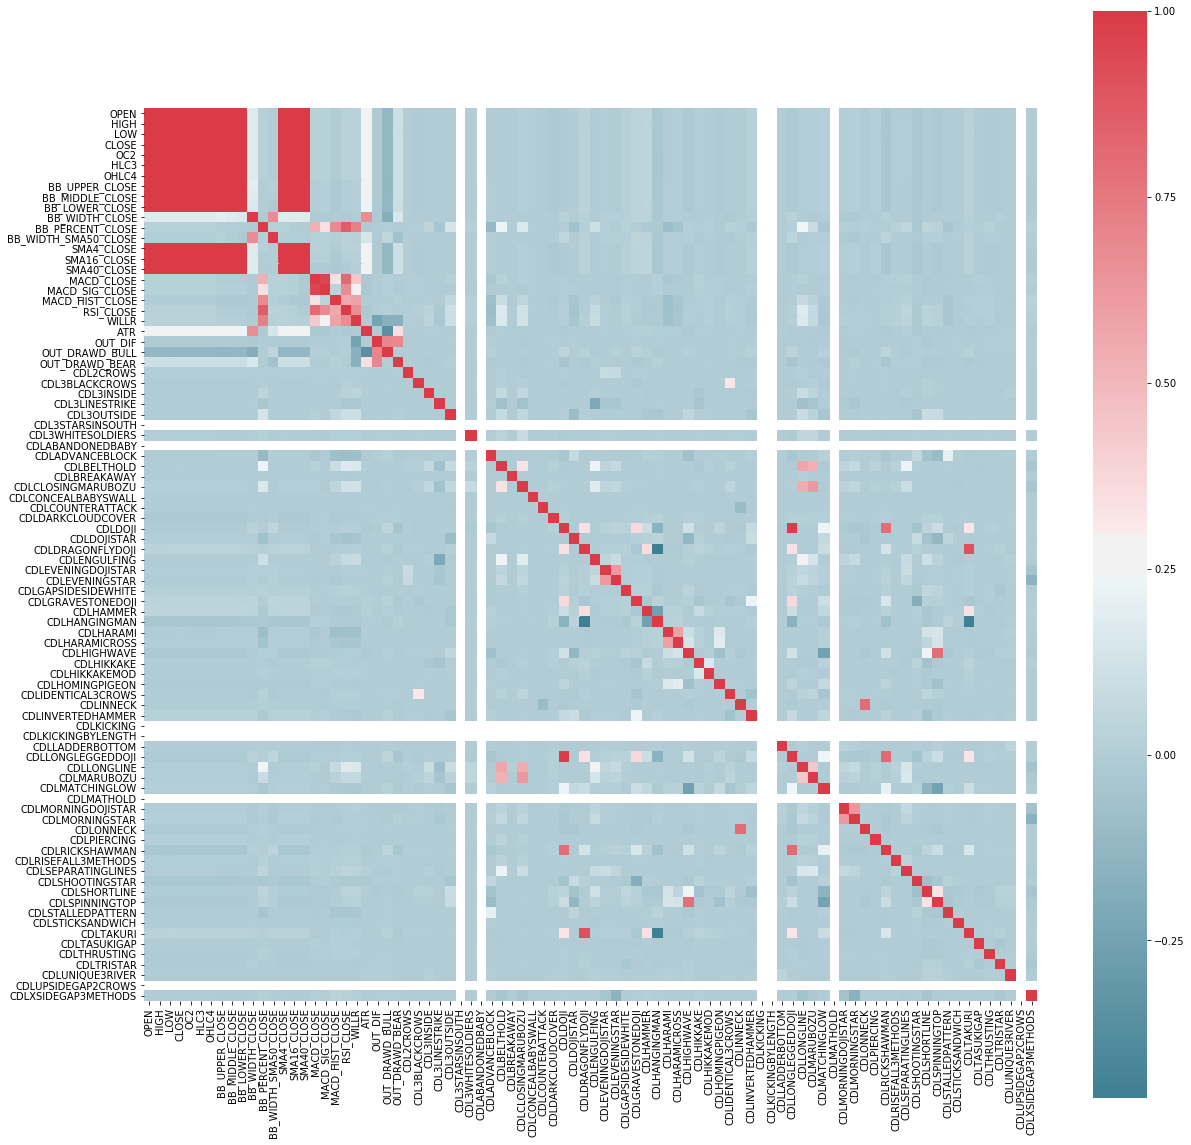

In [86]:
# Visualizo la matriz de correlación
f, ax = plt.subplots(figsize=(20, 20))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
# Scatterplot Matrix
scatter_matrix(df)


En primer lugar voy a mostrar algunas gráficas de 'features' en relación con diferentes salidas:

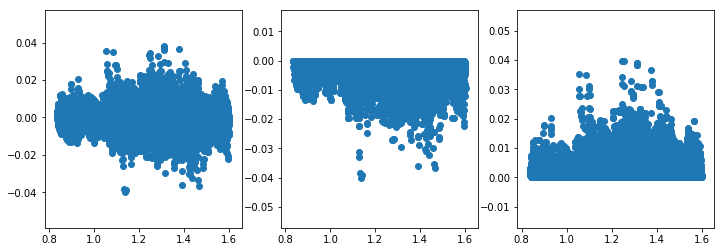

In [78]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(df.CLOSE.values, df.OUT_DIF.values)
plt.subplot(1,3,2)
plt.scatter(df.CLOSE.values, df.OUT_DRAWD_BULL.values)
plt.subplot(1,3,3)
plt.scatter(df.CLOSE.values, df.OUT_DRAWD_BEAR.values)

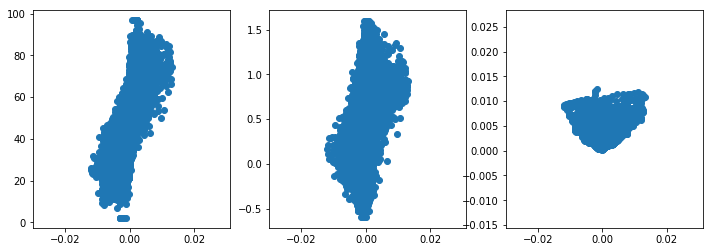

In [80]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(df.MACD_CLOSE.values, df.RSI_CLOSE.values)
plt.subplot(1,3,2)
plt.scatter(df.MACD_CLOSE.values, df.BB_PERCENT_CLOSE.values)
plt.subplot(1,3,3)
plt.scatter(df.MACD_CLOSE.values, df.ATR.values)